In [1]:
! pip install linearmodels
! pip install pystout

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 KB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import linearmodels as lm
import matplotlib.pyplot as plt
import seaborn as sns
from pystout import pystout

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_excel("/content/drive/MyDrive/University Shit /ECO475/Data/475 Dataset v1.xlsx") 
data["rep_gov"] = (data["governor_party"] == "Republican").astype(int)
data["Total Vehicles"] = data["Electric Vehicle (EV) Total"] + data["Non-Electric Vehicle Total"]

#data = data[data["Total Vehicles"] > 50]
data

,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Bachelor's degree or higher, 1990","Bachelor's degree or higher, 2000","Bachelor's degree or higher, 2007-11","Bachelor's degree or higher, 2016-20",Battery Electric Vehicles (BEVs),CI90LB017P_2020,CI90LB017_2020,CI90LB517P_2020,CI90LB517_2020,CI90LBALLP_2020,CI90LBALL_2020,CI90LBINC_2020,CI90UB017P_2020,CI90UB017_2020,CI90UB517P_2020,CI90UB517_2020,CI90UBALLP_2020,CI90UBALL_2020,CI90UBINC_2020,Civilian_labor_force_2000,Civilian_labor_force_2001,Civilian_labor_force_2002,Civilian_labor_force_2003,Civilian_labor_force_2004,Civilian_labor_force_2005,Civilian_labor_force_2006,Civilian_labor_force_2007,Civilian_labor_force_2008,Civilian_labor_force_2009,Civilian_labor_force_2010,Civilian_labor_force_2011,Civilian_labor_force_2012,Civilian_labor_force_2013,Civilian_labor_force_2014,Civilian_labor_force_2015,Civilian_labor_force_2016,Civilian_labor_force_2017,Civilian_labor_force_2018,Civilian_labor_force_2019,Civilian_labor_force_2020,Civilian_labor_force_2021,County,Date,Electric Vehicle (EV) Total,Employed_2000,Employed_2001,Employed_2002,Employed_2003,Employed_2004,Employed_2005,Employed_2006,Employed_2007,Employed_2008,Employed_2009,Employed_2010,Employed_2011,Employed_2012,Employed_2013,Employed_2014,Employed_2015,Employed_2016,Employed_2017,Employed_2018,Employed_2019,Employed_2020,Employed_2021,Federal Information Processing Standards (FIPS) Code,"Four years of college or higher, 1970","Four years of college or higher, 1980","High school diploma only, 1970","High school diploma only, 1980","High school diploma only, 1990","High school diploma only, 2000","High school diploma only, 2007-11","High school diploma only, 2016-20","Less than a high school diploma, 1970","Less than a high school diploma, 1980","Less than a high school diploma, 1990","Less than a high school diploma, 2000","Less than a high school diploma, 2007-11","Less than a high school diploma, 2016-20",MEDHHINC_2020,Med_HH_Income_Percent_of_State_Total_2020,Median_Household_Income_2020,Metro_2013,Non-Electric Vehicle Total,PCTPOV017_2020,PCTPOV517_2020,PCTPOVALL_2020,POV017_2020,POV517_2020,POVALL_2020,Percent Electric Vehicles,"Percent of adults completing four years of college or higher, 1970","Percent of adults completing four years of college or higher, 1980","Percent of adults completing some college (1-3 years), 1970","Percent of adults completing some college (1-3 years), 1980","Percent of adults completing some college or associate's degree, 1990","Percent of adults completing some college or associate's degree, 2000","Percent of adults completing some college or associate's degree, 2007-11","Percent of adults completing some college or associate's degree, 2016-20",Percent of adults with a bachelor's degree or higher 2007-11,Percent of adults with a bachelor's degree or higher 2015-19,"Percent of adults with a bachelor's degree or higher, 1990","Percent of adults with a bachelor's degree or higher, 2000","Percent of adults with a high school diploma only, 1970","Percent of adults with a high school diploma only, 1980","Percent of adults with a high school diploma only, 1990","Percent of adults with a high school diploma only, 2000","Percent of adults with a high school diploma only, 2007-11","Percent of adults with a high school diploma only, 2016-20","Percent of adults with less than a high school diploma, 1970","Percent of adults with less than a high school diploma, 1980","Percent of adults with less than a high school diploma, 1990","Percent of adults with less than a high school diploma, 2000","Percent of adults with less than a high school diploma, 2007-11","Percent of adults with less than a high school diploma, 2016-20",Plug-In Hybrid Electric Vehicles (PHEVs),Population 1990,Population 2000,Population 2010,Population 2020,Population 2021,Rural-Urban Continuum Code 2013,Rural-urban_Continuum_Code_2003,Rural-urban_Continuum_Code_2

# Summaries


In [6]:
sns.set(rc={"figure.figsize":(20, 10)})

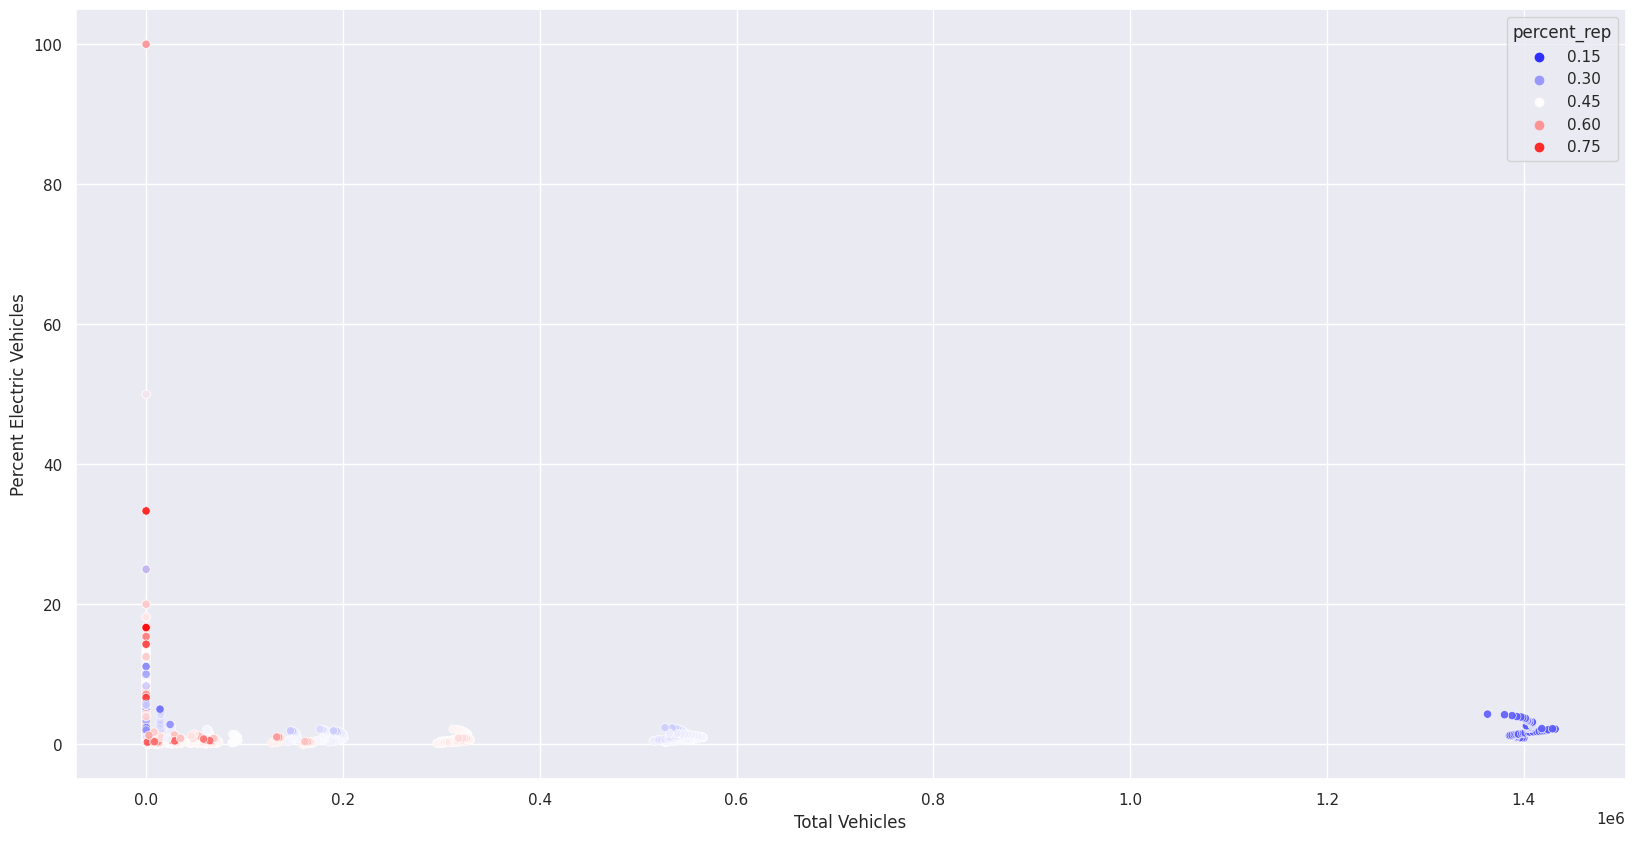

In [7]:
pal = sns.color_palette("bwr", as_cmap=True)

sc = sns.scatterplot(data = data, 
                     y = "Percent Electric Vehicles", x = "Total Vehicles", 
                     hue = data["percent_rep"], palette = pal, alpha=0.9)

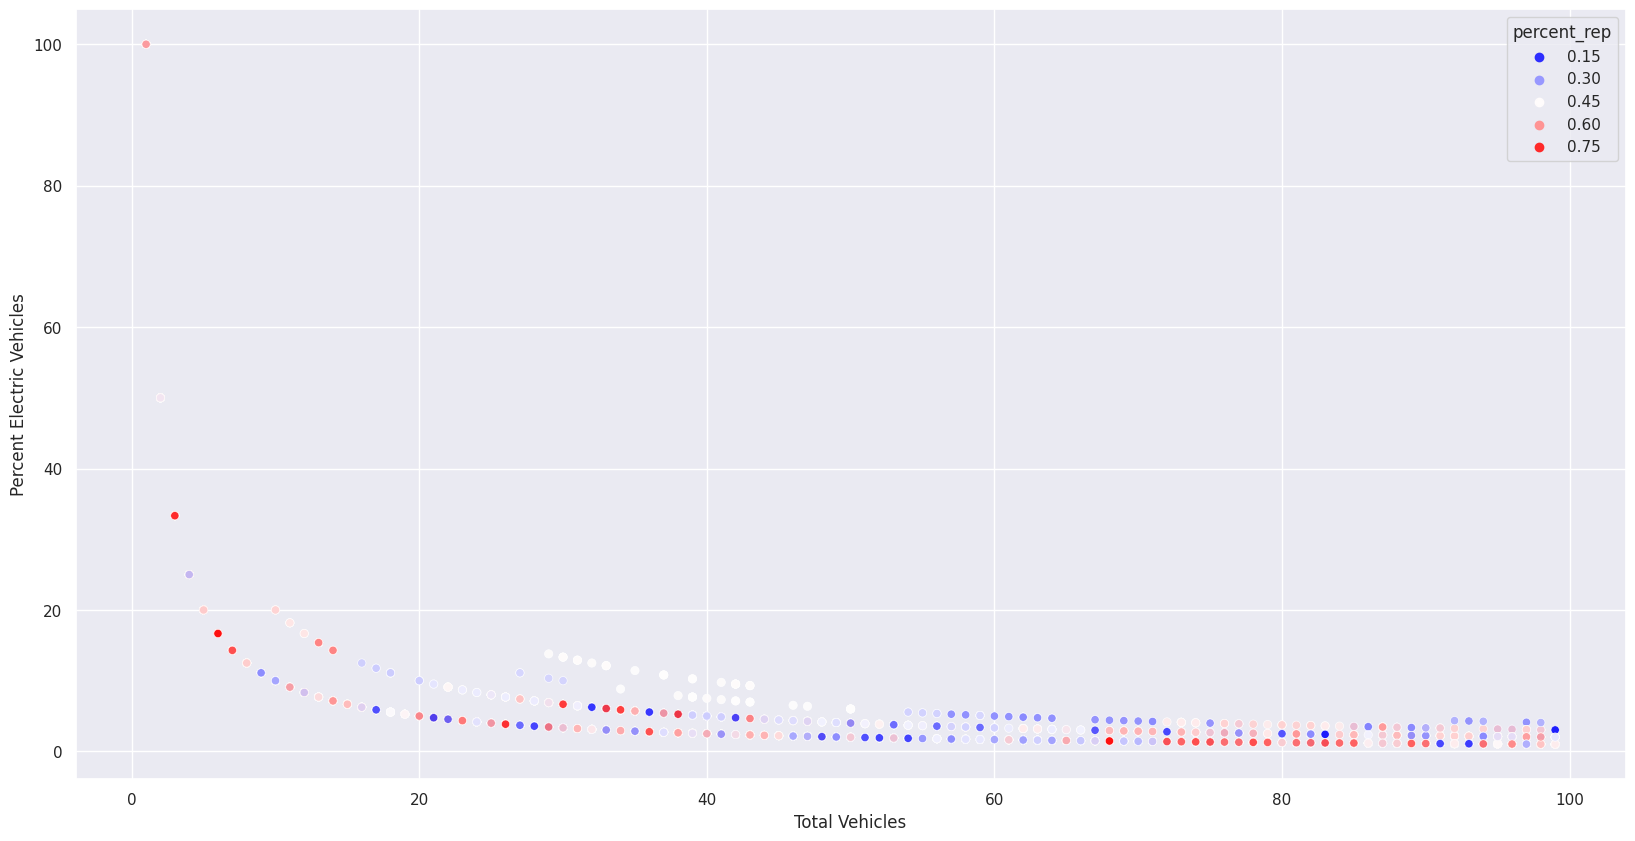

In [8]:
pal = sns.color_palette("bwr", as_cmap=True)

sc = sns.scatterplot(data = data[data["Total Vehicles"] < 100], 
                     y = "Percent Electric Vehicles", x = "Total Vehicles", 
                     hue = data["percent_rep"], palette = pal, alpha=0.9)

<Axes: xlabel='Date', ylabel='Number of Counties'>

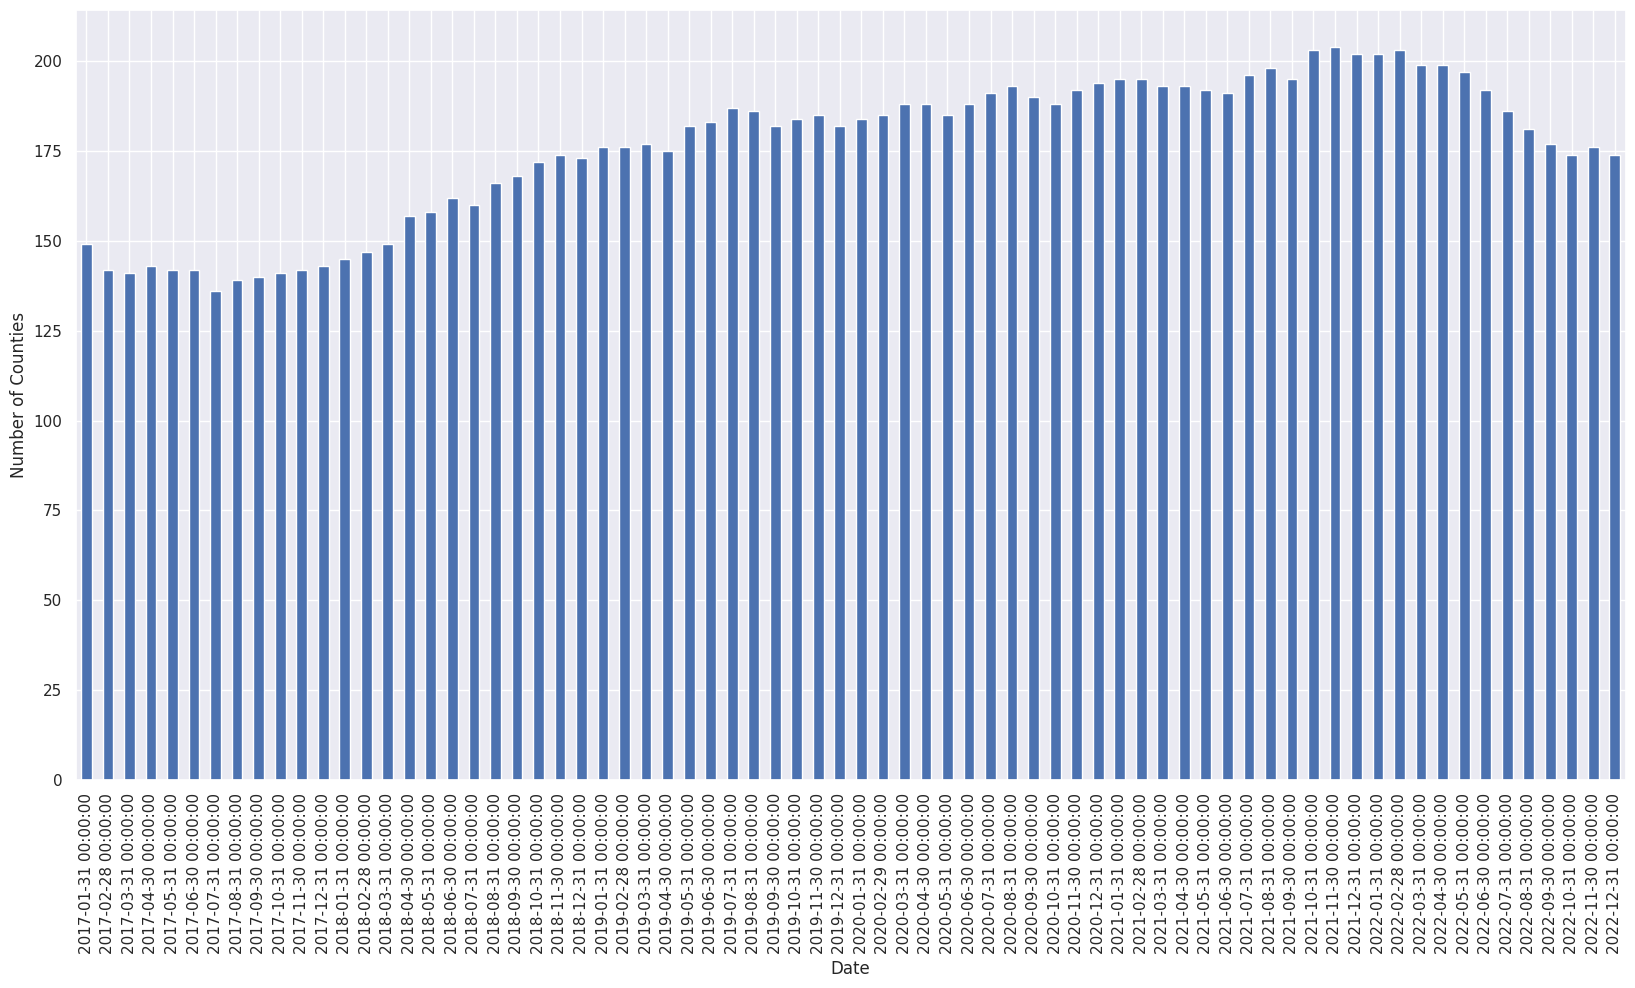

In [9]:
data.groupby("Date")["Federal Information Processing Standards (FIPS) Code"].nunique().plot(xlabel = "Date", ylabel = "Number of Counties", figsize = (20, 10), kind = "bar")

Date
2017-01-31     93081765
2017-02-28     92326210
2017-03-31     91799172
2017-04-30     93350628
2017-05-31     91287144
                ...    
2022-08-31    109505366
2022-09-30    106926213
2022-10-31    104266052
2022-11-30    102902672
2022-12-31    101607913
Name: Population 2021, Length: 72, dtype: int64


<Axes: xlabel='Date', ylabel='Population Counted'>

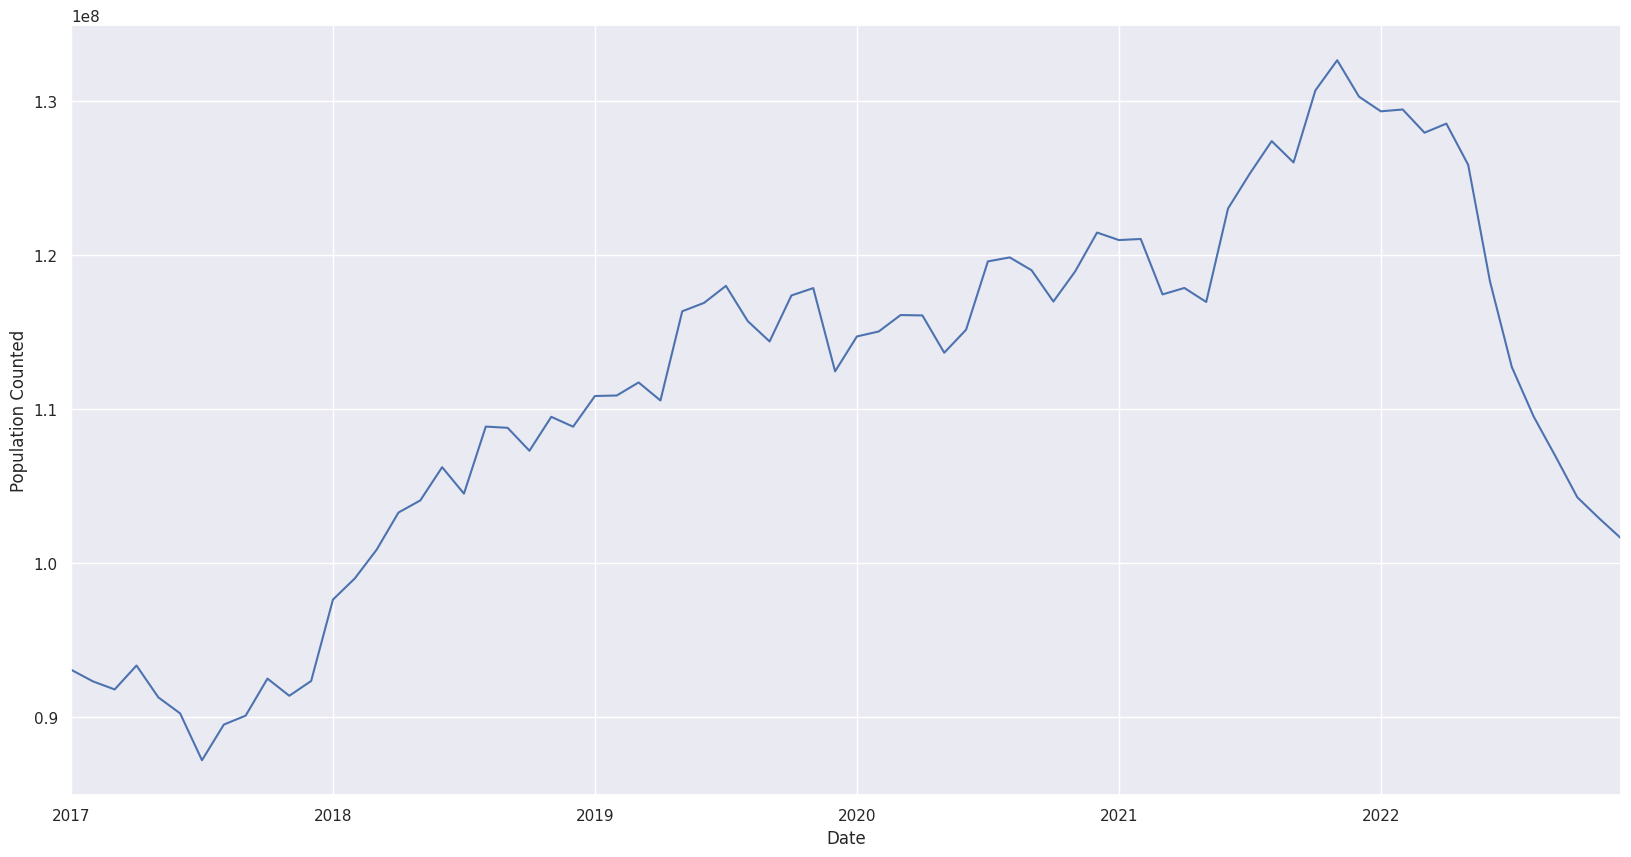

In [10]:
f = {
        'Federal Information Processing Standards (FIPS) Code' : 'unique', 
        'Population 2021' : 'sum'
}

g = data.groupby("Date") 
print(g.agg(f)["Population 2021"])
g.agg(f)["Population 2021"].plot(xlabel = "Date", ylabel = "Population Counted", figsize = (20, 10), kind = "line")

<Axes: xlabel='Date', ylabel='Average EV % of Vehicle Population'>

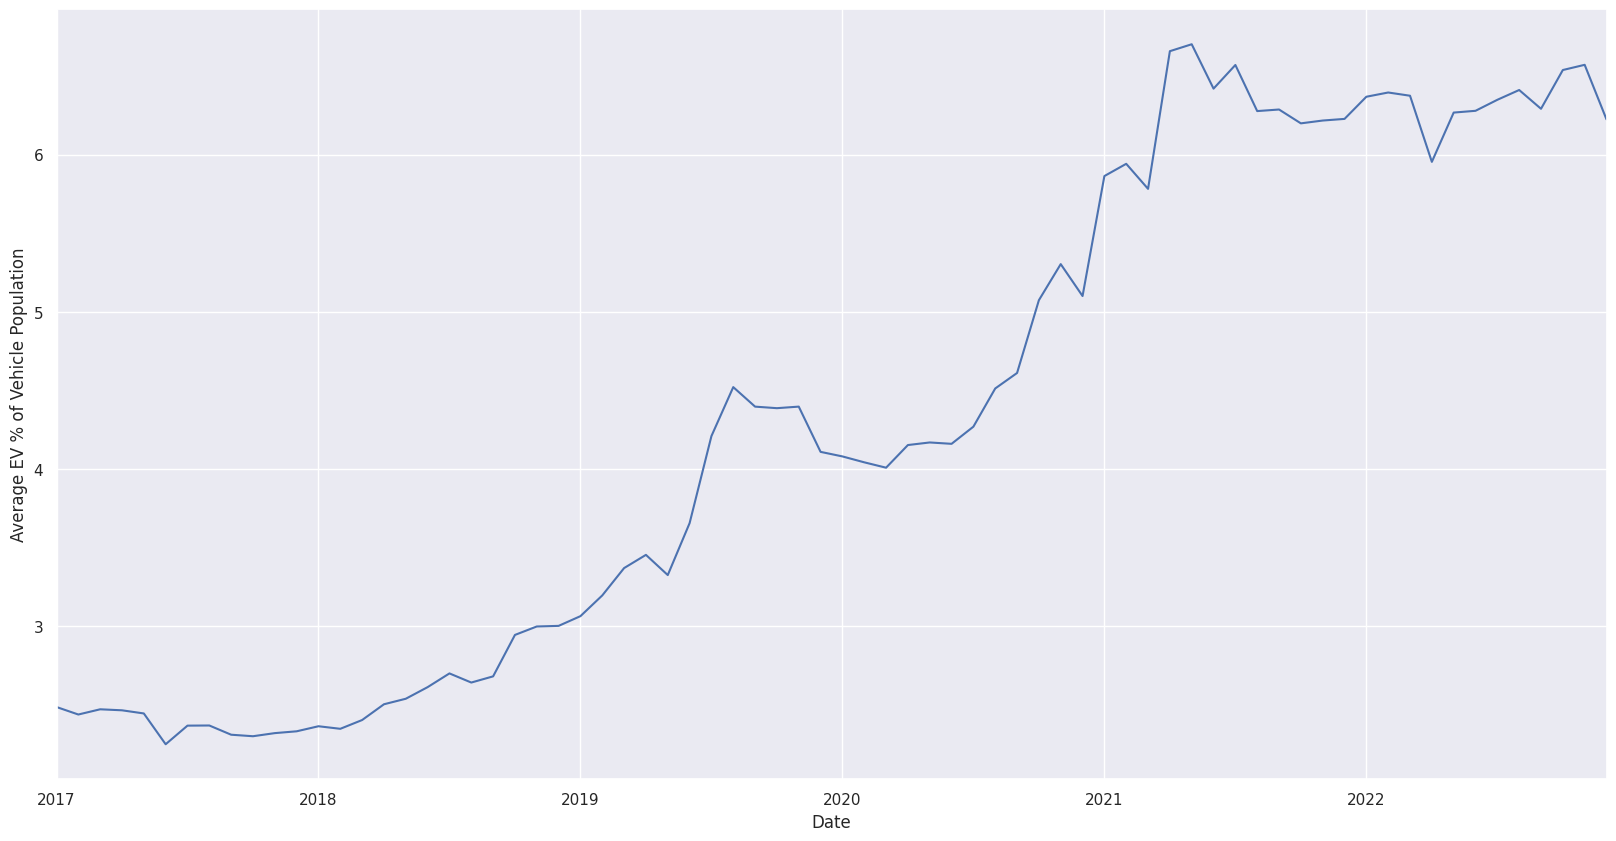

In [11]:
no_dupe = data.drop_duplicates(subset = ["Federal Information Processing Standards (FIPS) Code", "Date"])
no_dupe.groupby("Date")["Percent Electric Vehicles"].mean().plot(xlabel = "Date", ylabel = "Average EV % of Vehicle Population", figsize = (20, 10), kind = "line")

<Axes: ylabel='Frequency'>

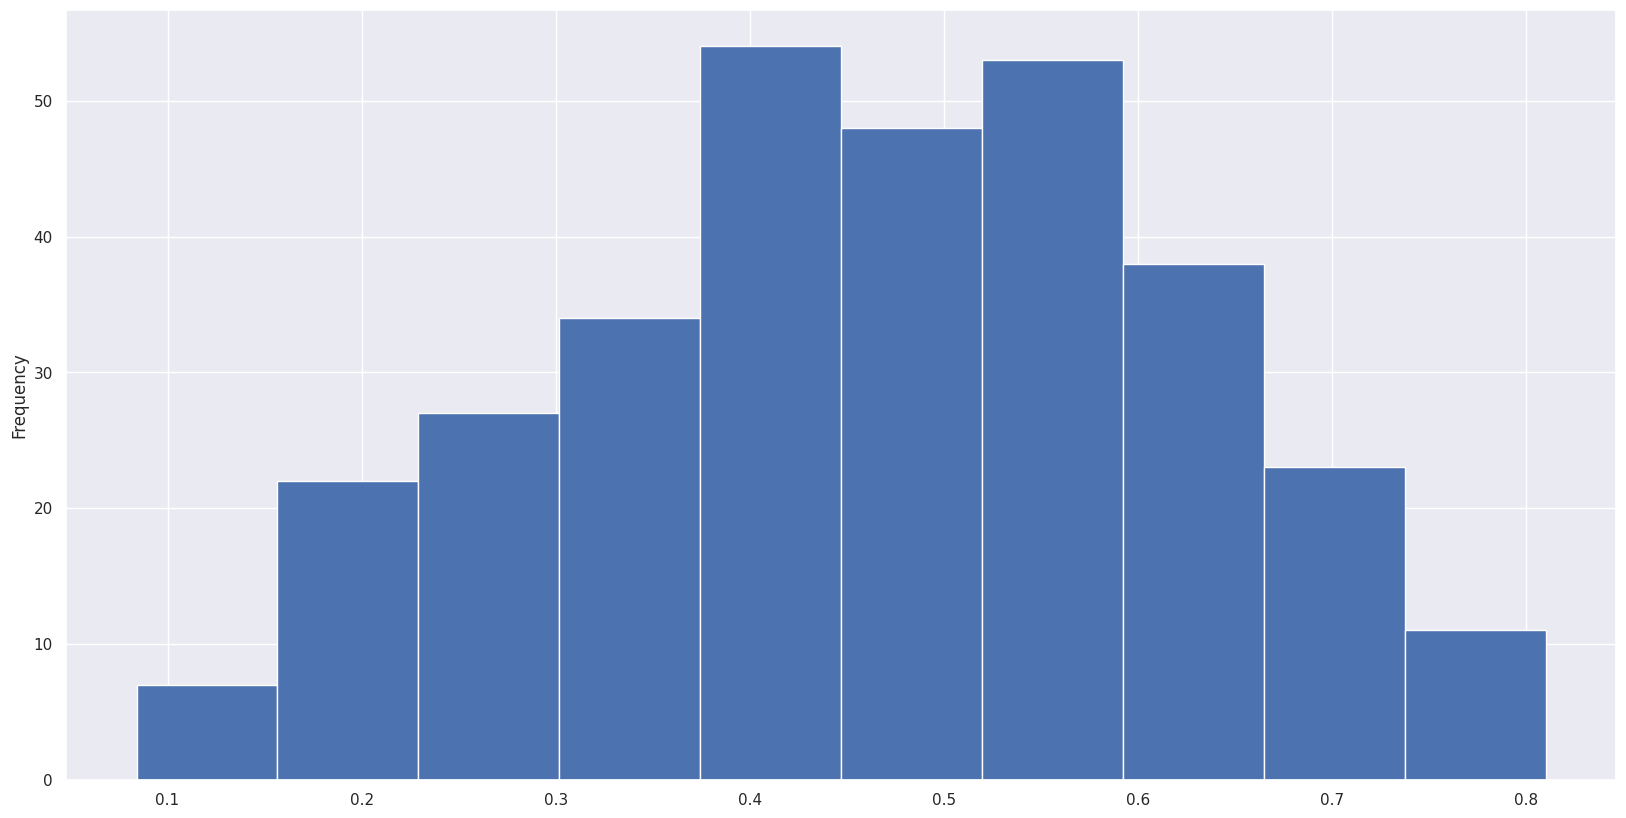

In [12]:
election_subset = data.drop_duplicates(subset = "county_fips")
election_subset["percent_rep"].plot(xlabel = "Republican Vote Share", figsize = (20, 10), kind = "hist")

<Axes: ylabel='Frequency'>

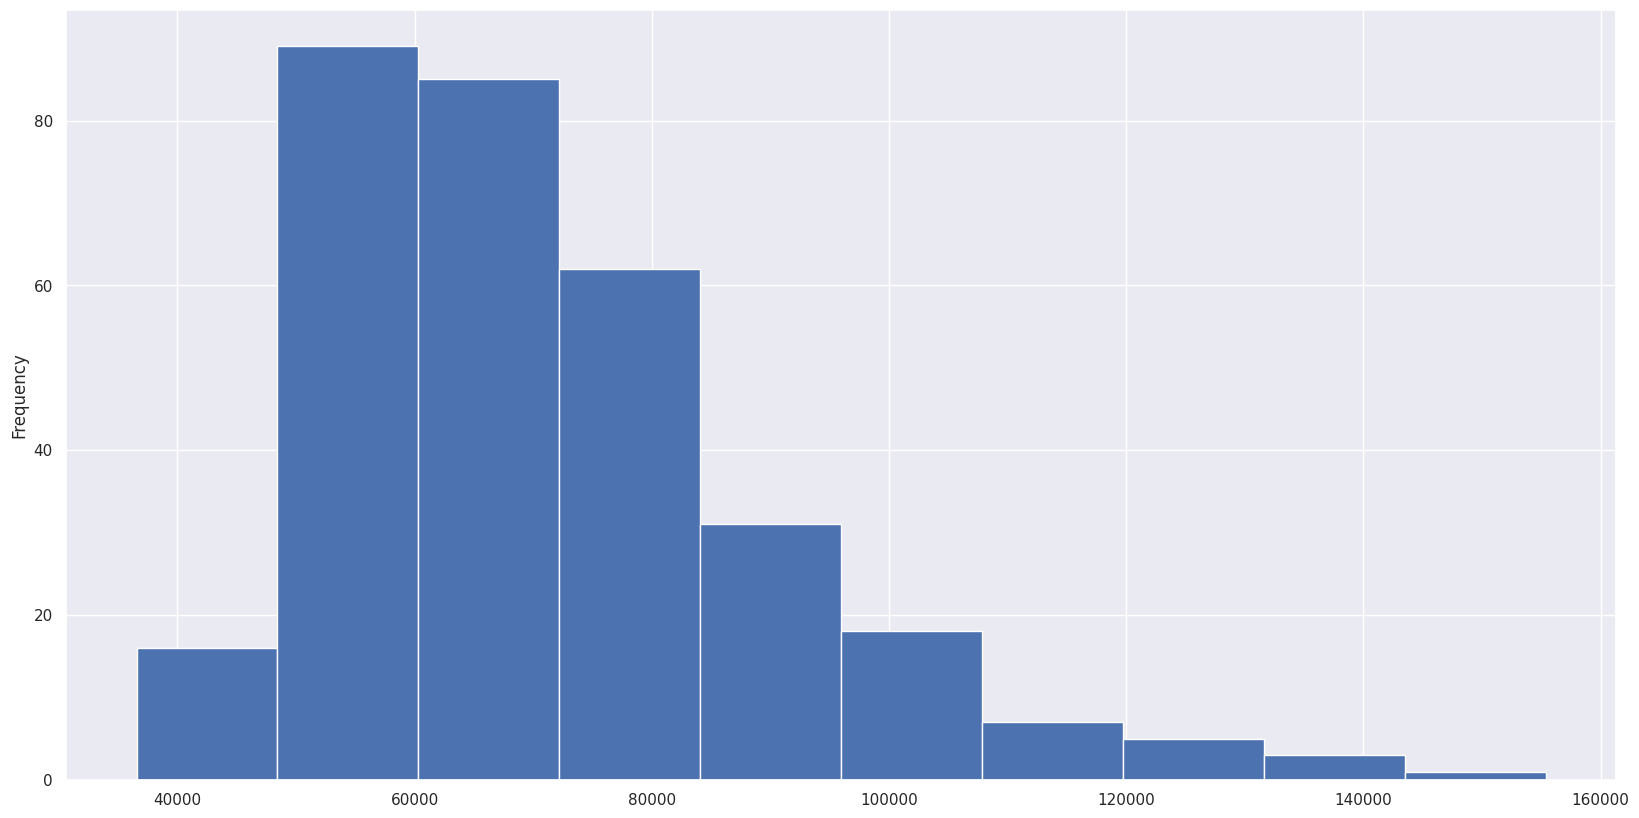

In [13]:
election_subset["Median_Household_Income_2020"].plot(xlabel = "Median 2020 household income", figsize = (20, 10), kind = "hist")

# Initial Regression

In [14]:
vars = ["Percent Electric Vehicles", "percent_rep", "percentchange", "percent_republican_x", "republican_majority_x", "republican_supermajority_x", "percent_republican_y", "republican_majority_y", "republican_supermajority_y",
        "rep_gov", "Median_Household_Income_2020", "Percent of adults with a bachelor's degree or higher 2015-19", "Population 2021", "PCTPOVALL_2020", "Unemployment_rate_2020", "n_charging_stations", "U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon", 
        "year_x", "state_name_x", "Date", "County",
        "Battery Electric Vehicles (BEVs)", "Plug-In Hybrid Electric Vehicles (PHEVs)", "Electric Vehicle (EV) Total", "Non-Electric Vehicle Total", "Total Vehicles"]

dataset = data[vars]
dataset = dataset[dataset["Total Vehicles"] > 50]
dataset["year_x"] = pd.to_datetime(dataset["year_x"], format = "%Y")

dataset = dataset.set_index(["state_name_x", "year_x"])

dataset

Percent Electric Vehicles  percent_rep  \
state_name_x year_x                                               
Alabama      2017-01-01                       1.49     0.736466   
Arizona      2017-01-01                       0.21     0.476684   
             2017-01-01                       0.43     0.397088   
             2017-01-01                       0.74     0.562109   
             2017-01-01                       1.18     0.623242   
...                                            ...          ...   
Washington   2022-01-01                       1.28     0.569975   
             2022-01-01                       0.86     0.537039   
             2022-01-01                       1.92     0.370182   
             2022-01-01                       0.81     0.427795   
             2022-01-01                       0.38     0.536785   

                         percentchange  percent_republican_x  \
state_name_x year_x                                            
Alabama      2017-01-01       0.983946              0.685714   
Arizona      2017-01-01       1.009955              0.583333   
             2017-01-01       1.005395              0.583333   
             2017-01-01       1.029828              0.583333   
             2017-01-01       1.025383              0.583333   
...                                ...                   ...   
Washington   2022-01-01       1.024664              0.418367   
             2022-01-01       0.976866              0.418367   
             2022-01-01       0.983910              0.418367   
             2022-01-01       1.003252              0.418367   
             2022-01-01       0.979086              0.418367   

                         republican_majority_x  republican_supermajority_x  \
state_name_x year_x                                                          
Alabama      2017-01-01                      1                           1   
Arizona      2017-01-01                      1                           0   
             2017-01-01                      1                           0   
             2017-01-01                      1                           0   
             2017-01-01                      1                           0   
...                                        ...                         ...   
Washington   2022-01-01                      0                           0   
             2022-01-01                      0                           0   
             2022-01-01                      0                           0   
             2022-01-01                      0                           0   
             2022-01-01                      0                           0   

                         percent_republican_y  republican_majority_y  \
state_name_x year_x                                                    
Alabama      2017-01-01              0.764706                      1   
Arizona      2017-01-01              0.566667                      1   
             2017-01-01              0.566667                      1   
             2017-01-01              0.566667                      1   
             2017-01-01              0.566667                      1   
...                                       ...                    ...   
Washington   2022-01-01              0.408163                      0   
             2022-01-01              0.408163                      0   
             2022-01-01              0.408163                      0   
             2022-01-01              0.408163                      0   
             2022-01-01              0.408163                      0   

                         republican_supermajority_y  rep_gov  \
state_name_x year_x                                            
Alabama      2017-01-01                           1        1   
Arizona      2017-01-01                           0        1   
             2017-01-01                           0        1   
             2017-01-01                         

# Reg 1 - Just voting and EV w/ fixed effects 

In [15]:
exog1 = ["percent_rep", "percentchange", "Total Vehicles"]

y1 = dataset["Percent Electric Vehicles"]
x1 = sm.add_constant(dataset[exog1])

In [16]:
mod1 = lm.PanelOLS(dependent = y1, exog = x1, entity_effects = True, time_effects = True) 
res1 = mod1.fit(cov_type="robust")
print(res1.summary)

                              PanelOLS Estimation Summary                              
Dep. Variable:     Percent Electric Vehicles   R-squared:                        0.0959
Estimator:                          PanelOLS   R-squared (Between):             -0.3409
No. Observations:                       9121   R-squared (Within):               0.0821
Date:                       Tue, Apr 04 2023   R-squared (Overall):              0.0931
Time:                               20:38:23   Log-likelihood                   -8852.3
Cov. Estimator:                       Robust                                           
                                               F-statistic:                      320.85
Entities:                                 40   P-value                           0.0000
Avg Obs:                              228.03   Distribution:                  F(3,9073)
Min Obs:                              1.0000                                           
Max Obs:                        

# Reg 2 - Demographic Controls

In [17]:
exog2 = ["percent_rep", "percentchange", "Median_Household_Income_2020", "Percent of adults with a bachelor's degree or higher 2015-19", "Population 2021", "PCTPOVALL_2020", "Total Vehicles", "Unemployment_rate_2020"]

y2 = dataset["Percent Electric Vehicles"]
x2 = sm.add_constant(dataset[exog2])

In [18]:
mod2 = lm.PanelOLS(dependent = y2, exog = x2, entity_effects = True, time_effects = True) 
res2 = mod2.fit(cov_type="robust")
print(res2.summary)

                              PanelOLS Estimation Summary                              
Dep. Variable:     Percent Electric Vehicles   R-squared:                        0.2034
Estimator:                          PanelOLS   R-squared (Between):             -0.5634
No. Observations:                       9121   R-squared (Within):               0.1690
Date:                       Tue, Apr 04 2023   R-squared (Overall):              0.1649
Time:                               20:38:23   Log-likelihood                   -8274.8
Cov. Estimator:                       Robust                                           
                                               F-statistic:                      289.51
Entities:                                 40   P-value                           0.0000
Avg Obs:                              228.03   Distribution:                  F(8,9068)
Min Obs:                              1.0000                                           
Max Obs:                        

# Reg 3 - All Controls

In [19]:
exog3 = ["percent_rep", "percentchange", "percent_republican_x", "republican_majority_x", "republican_supermajority_x", "percent_republican_y", "republican_majority_y", "republican_supermajority_y", "rep_gov", "Median_Household_Income_2020", 
         "Percent of adults with a bachelor's degree or higher 2015-19", "Population 2021", "PCTPOVALL_2020", "n_charging_stations", "U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon", "Total Vehicles", "Unemployment_rate_2020"]

y3 = dataset["Percent Electric Vehicles"]
x3 = sm.add_constant(dataset[exog3])

In [20]:
mod3 = lm.PanelOLS(dependent = y3, exog = x3, entity_effects = True, time_effects = True) 
res3 = mod3.fit(cov_type="robust")
print(res3.summary)

                              PanelOLS Estimation Summary                              
Dep. Variable:     Percent Electric Vehicles   R-squared:                        0.2368
Estimator:                          PanelOLS   R-squared (Between):             -0.3834
No. Observations:                       9121   R-squared (Within):               0.2237
Date:                       Tue, Apr 04 2023   R-squared (Overall):              0.2329
Time:                               20:38:24   Log-likelihood                   -8079.7
Cov. Estimator:                       Robust                                           
                                               F-statistic:                      165.34
Entities:                                 40   P-value                           0.0000
Avg Obs:                              228.03   Distribution:                 F(17,9059)
Min Obs:                              1.0000                                           
Max Obs:                        

In [21]:
pystout(models=[res1, res2, res3],
        file='test_table.tex',
        addnotes=["Note: * p $ < $ 0.1, ** p $ < $ 0.05, *** p $ < $ 0.01",
                  "Note 2: State and Year fixed effects included for all specifications"],
        digits = 4,
        stars = {.1:'*',.05:'**',.01:'***'},
        endog_names=['Base', 'Demographic Controls', 'All Controls'],
        varlabels={'const':'Constant',
                   'percent_rep':'\% Republican Vote Share 2016',
                   'percentchange':'\% Change in 2020',
                   "percent_republican_x": "\% Republican House",
                   "republican_majority_x": "Republican House Majority",
                   "republican_supermajority_x": "Republican House Supermajority",
                   "percent_republican_y": "\% Republican Senate",
                   "republican_majority_y": "Republican Senate Majority",
                   "republican_supermajority_y": "Republican Senate Supermajority",
                   "rep_gov": "Republican Governor",
                   "Median_Household_Income_2020": "Median Household Income",
                   "Percent of adults with a bachelor's degree or higher 2015-19": "\% with a bachelor's or higher",
                   "Population 2021": "Population",
                   "PCTPOVALL_2020": "Percent in Poverty",
                   "n_charging_stations": "Number of Charging Stations",
                   "U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon": "Gasoline Prices"
                   },
        modstat={'nobs':'N','rsquared':'R\sym{2}','fvalue':'F-stat'},
        scientific_notation = True,
        title = "Table 1"
        )

files.download('test_table.tex')

/usr/local/lib/python3.9/dist-packages/pystout/pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
/usr/local/lib/python3.9/dist-packages/pystout/pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))
/usr/local/lib/python3.9/dist-packages/pystout/pystout.py:377: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(pd.DataFrame([r],index=[value]))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>